In [105]:
import warnings
from collections import Counter
from tqdm import tqdm
import graphviz
import numpy as np
import pandas as pd
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
from pandas.io.formats.style import plt
from sklearn.tree import plot_tree
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
import seaborn as sns
from google.colab  import drive
drive.mount("/content/drive")
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import seaborn
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import scipy.cluster.hierarchy as sch
from pathlib import Path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
class Graficar:
  def __init__(self, colores=None):
    if colores is None:
      self.colores = {
          'femenino':'#ff69b4',
          'masculino':'#7858da',
          'correcto':'#1CDB59',
          'incorrecto':'#fa1e1e',
          'c1':'#79216d',
          'c2':'#ca1e3f',
          'c3':'#b26116',
          'c4':'#a0933a',
          'c5':'#a3f789'
      }
    else:
      self.colores = colores

    self.color_discrete_sequence=[self.colores[c] for c in ['c1','c2','c3','c4','c5']]
    self.color_continuous_scale = ["#fff", self.colores['c1']]

  def with_colors(self, colors):
    new_colors: dict = self.colores
    new_colors.update(colors)
    return Graficar(new_colors)

  def heatmap(self, df, **kwargs):
    return px.imshow(df, color_continuous_scale=self.color_continuous_scale,**kwargs)

  def box(self, df, x=None, y=None, title=None, notched=True, **kwargs):
    if title is None:
      title=f'Boxplot {x} vs {y}' if x is not None else f'Boxplot {y}'
    return px.box(df, x=x, y=y, title=title, notched=notched,
                  color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def histogram(self, df=None, x=None, text_auto=True,**kwargs):
    return px.histogram(df, x=x, text_auto=text_auto, 
                        color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def scatter(self, df: DataFrame, x: str, y: str, color: str = None, correct_incorrect_map=None,
        **kwargs) -> go.Figure:
    """
    Scatter plot

    Args:
        df (): Dataframe with the data.
        x (): Column to display in the x-axis. (Numerical).
        y (): Column to display in the y-axis. (Numerical).
        color (): Column to separate points by color (Categorical).
        correct_incorrect_map (): A dictionary that maps the columns value to the assigned colors.
        **kwargs (): Aditional parameters to pass to plotly.express.imshow.

    Returns:
        A Figure that can be displayed with the method show().

    """
    if correct_incorrect_map is None:
        color_discrete_sequence = self.color_discrete_sequence
        color_discrete_map = None
    else:
        color_discrete_sequence = None
        color_discrete_map = {
            correct_incorrect_map['correct']: self.colors['correct'],
            correct_incorrect_map['incorrect']: self.colors['incorrect']
        }
    return px.scatter(
        data_frame=df,
        x=x,
        y=y,
        color=color,
        color_discrete_sequence=color_discrete_sequence,
        color_discrete_map=color_discrete_map, **kwargs)

  def pyramid(self, df, x, bins, cat_col, cat1, cat1name, cat1color, cat2, cat2name, cat2color):
    min = df[x].min()
    max = df[x].max()
    limites = [round(x) for x in np.linspace(min, max, bins)]
    labels = [f'[{lim_min}-{lim_max})' 
              for (lim_min, lim_max) in zip(limites[0:bins-1],limites[1:bins])]

    bins_1 = pd.cut(df.loc[df[cat_col] == cat1][x], bins=limites, labels=labels, include_lowest=True)
    bins_2 = pd.cut(df.loc[df[cat_col] == cat2][x], bins=limites, labels=labels, include_lowest=True)

    bins_1.name = cat1name
    bins_2.name = cat2name

    grouped_1 = bins_1.groupby(bins_1).count()
    grouped_2 = bins_2.groupby(bins_2).count()

    data = pd.DataFrame([grouped_1, grouped_2]).transpose()

    y = data.index
    x_1 = data[cat1name]
    x_2 = data[cat2name] * (-1)
    meta = data[cat2name]

    fig = go.Figure()
    bar1 = go.Bar(y=y, x=x_1, name=cat1name, orientation = 'h', 
                  texttemplate='%{x}',marker_color=cat1color)
    bar2 = go.Bar(y=y, x=x_2, name=cat2name, orientation = 'h', 
                  texttemplate='%{meta}',marker_color=cat2color,meta=meta)
    fig.add_trace(bar1)
    fig.add_trace(bar2)
    fig.update_layout(title='Pirámide poblacional', barmode='relative',bargap=0.0, 
                      bargroupgap = 0 )
    return fig
graficar = Graficar()

# Punto 1

In [3]:
parent_General = r'/content/drive/MyDrive/Uniquindío/Maestría en Ingeniería/Cohorte II'

parent = parent_General
archivo = r'/Dataset_final_limpio.xlsx'
df = pd.read_excel(''.join([parent, archivo]))

# Punto 2

In [4]:
from sklearn.feature_selection import SelectKBest
from numpy import array 
X = df.drop(['Gano','grade','cluster','Unnamed: 0'], axis=1)
y = df['Gano']

best=SelectKBest(k=6)

features = array(X.columns)
features

X_new = best.fit_transform(X, y)

filter_1 = best.get_support()
print(features[filter_1])

['TaskStrategies' 'SRL' 'Atry to lecture' 'days_act' 'num_events'
 'num_ses']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            494 non-null    int64  
 1   GoalSetting           494 non-null    float64
 2   StrategicPlanning     494 non-null    float64
 3   SelfEvaluation        494 non-null    float64
 4   TaskStrategies        494 non-null    float64
 5   Elaboration           494 non-null    float64
 6   HelpSeeking           494 non-null    float64
 7   SRL                   494 non-null    float64
 8   only lecture          494 non-null    int64  
 9   Atry to lecture       494 non-null    int64  
 10  explore               494 non-null    int64  
 11  only asessment        494 non-null    int64  
 12  Lcomplete to Atry     494 non-null    int64  
 13  lecture to Acomplete  494 non-null    int64  
 14  hrs                   494 non-null    int64  
 15  prior_exp             4

In [6]:
#Se seleccionan las dimensiones, 3 para poder graficar
y = np.array(df['Gano'])
X = np.array(df[['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses']])

Nc = range(1, 15)
#se va a aplicar la tecnica del codo
kmeans = [KMeans(n_clusters=i) for i in Nc]
print("Kmeans")
print(kmeans)
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
print (" El puntaje")
print (score)

Kmeans
[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10), KMeans(n_clusters=11), KMeans(n_clusters=12), KMeans(n_clusters=13), KMeans(n_clusters=14)]
 El puntaje
[-17590004.392528236, -4004658.3076156205, -2043508.1872558957, -1306931.2038719985, -897709.7697239988, -656686.0512362208, -573047.933526006, -502441.4495161014, -437847.48608055466, -393791.7314036249, -353996.44238619733, -332391.20078839053, -304510.7810092037, -282402.2831149489]


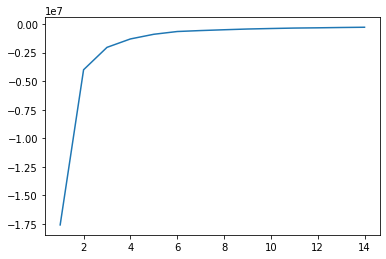

In [7]:
plt.plot(Nc,score)

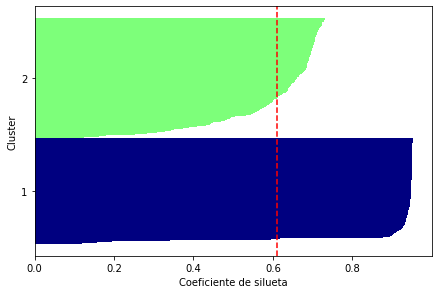

In [8]:
# basado en  Sebastian Raschka y Vahid Mijalili
kmeans = KMeans(n_clusters=2,
            init='k-means++', 
            random_state=1)
y_kmeans = kmeans.fit_predict(X)

cluster_labels = np.unique(y_kmeans)
silueta = silhouette_samples(X, y_kmeans, metric='euclidean')
n_clusters = cluster_labels.shape[0]
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silueta[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.tight_layout()
plt.xlabel('Coeficiente de silueta')
plt.ylabel('Cluster')
plt.show()

array([[  0.83333333,   1.66666667,   0.        ,  13.        ,
          2.        ,  16.        ],
       [  1.        ,   2.20833333,   0.        ,   1.        ,
          1.        ,   1.        ],
       [  1.        ,   1.47222222,   0.        ,   1.        ,
          1.        ,   1.        ],
       ...,
       [  4.        ,   3.95833333, 170.        ,  13.        ,
        269.        ,  36.        ],
       [  2.5       ,   2.01388889, 180.        ,  21.        ,
        407.        ,  36.        ],
       [  2.5       ,   3.38888889, 190.        ,  16.        ,
        323.        ,  24.        ]])

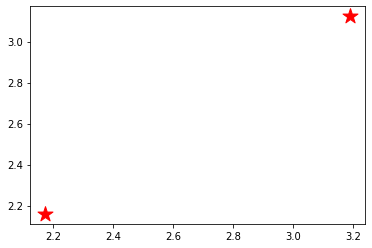

In [9]:
# Basado en Sebastian Raschka y Vahid Mijalili
kmeans = KMeans(n_clusters=2,
            init='k-means++',
            random_state=1)
modelo_kmeans = kmeans.fit(X)
y_kmeans = modelo_kmeans.predict(X)
df['cluster'] = y_kmeans
C = kmeans.cluster_centers_
plt.scatter(C[:, 0], C[:, 1],
            s=250, marker='*', c='red', label='centroids')

X

In [10]:
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

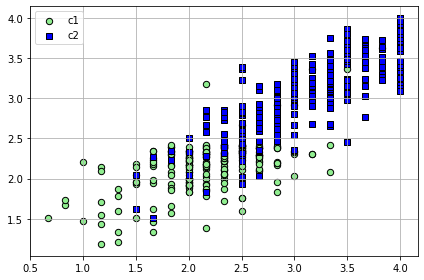

In [11]:
marker=['o', ]

plt.scatter(X[y_kmeans == 0, 0],
            X[y_kmeans == 0, 1],
            s=40,
            c='lightgreen',
            edgecolor='black',
            marker='o',
            label='c1')

plt.scatter(X[y_kmeans == 1, 0],
            X[y_kmeans == 1, 1],
            s=40,
            c='blue',
            edgecolor='black',
            marker='s',
            label='c2')


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

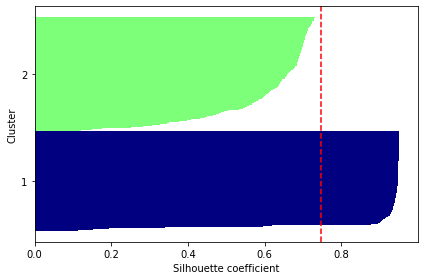

In [12]:
# tomado de Sebastian Raschka y Vahid Mijalili
cluster_labels = np.unique(y_kmeans)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_kmeans, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_06.png', dpi=300)
plt.show()

In [13]:
def hallarMejorParametro (parameter_grid, model):
  mejor_puntaje = -1 
  mejor_parametro = 0
  for g in parameter_grid:
    model.set_params(**g)
    model.fit(df2)
    # check how many unique labels do you have
    res = np.unique(model.labels_)
    #print ("shape")
    #print (res.shape)
    if res.shape[0]>1:
      coeficiente_silueta = metrics.silhouette_score(df2, model.labels_)
      print('parametro: ', g, 'puntaje: ', coeficiente_silueta)
      if coeficiente_silueta >= mejor_puntaje:
          mejor_puntaje = coeficiente_silueta
          mejor_parametro = g
  

  return mejor_parametro

In [14]:
parent_General = r'/content/drive/MyDrive/Uniquindío/Maestría en Ingeniería/Cohorte II'

parent = parent_General
archivo = r'/Dataset_final_limpio.xlsx'
df2 = pd.read_excel(''.join([parent, archivo]))
df2=df2.drop(['Gano','grade','cluster','Unnamed: 0'], axis=1)
Nc = range(1, 21)
parametros = {'n_clusters': Nc}

parameter_grid = ParameterGrid(parametros)

list(parameter_grid)
model = KMeans()
mejor_p= hallarMejorParametro(parameter_grid, model)
print (mejor_p)

parametro:  {'n_clusters': 2} puntaje:  0.7290859519701112
parametro:  {'n_clusters': 3} puntaje:  0.6650872268069478
parametro:  {'n_clusters': 4} puntaje:  0.6294459710509659
parametro:  {'n_clusters': 5} puntaje:  0.596470523282832
parametro:  {'n_clusters': 6} puntaje:  0.5904822759087006
parametro:  {'n_clusters': 7} puntaje:  0.5572504441432203
parametro:  {'n_clusters': 8} puntaje:  0.5418426624588085
parametro:  {'n_clusters': 9} puntaje:  0.5454883684905226
parametro:  {'n_clusters': 10} puntaje:  0.5334964555801716
parametro:  {'n_clusters': 11} puntaje:  0.5286484435779915
parametro:  {'n_clusters': 12} puntaje:  0.5094709804367082
parametro:  {'n_clusters': 13} puntaje:  0.5141585147527447
parametro:  {'n_clusters': 14} puntaje:  0.5018914915740286
parametro:  {'n_clusters': 15} puntaje:  0.27832505784569594
parametro:  {'n_clusters': 16} puntaje:  0.4936913863760648
parametro:  {'n_clusters': 17} puntaje:  0.26702266016040715
parametro:  {'n_clusters': 18} puntaje:  0.2681

Mediante la técnica del codo y la selección de hiperparámetros, se encuentra que la cantidad de grupos óptimo es dos. Con estos grupos, la mejor puntuación obtenida fue de 0.73, esta baja puntuación es debida a la poca separabilidad que hay entre los clústers, que se puede observar en el scatter plot, ambos clúster están muy cercanos y por lo tanto es dificil distinguir uno del otro.

Esto concuerda con el estudio realizado con los algoritmos de clasificación, observamos que con las variables seleccionadas tenemos dos grupos (Los estudiantes que ganaron y los que perdieron), para validar esto, se asociará a cada grupo una etiqueta relacionada con el resultado del curso (Si ganó o no), de ser cierta esta hipótesis, deberíamos encontrar un buen f1-score.

# Punto 3


In [15]:
centroide0 = C[0,:]
centroide1 = C[1,:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses'],y=centroide0, mode='lines',name='Centroide 0'))
fig.add_trace(go.Scatter(x=['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses'],y=centroide1, mode='lines', name='Centroide 1'))
fig.show()

Al analizar el gráfico anterior, podemos asociar el clúster 0 a aquellos estudiantes que perdieron, y el clúster 1 a aquellos estudiantes que ganaron (Esto es debido a que ya sabemos de análisis anteriores que entre mas num_events y Atry to lecture, mas probabilidad de ganar).

In [16]:
df['Gano_predict'] = list(map(lambda x: 'NO' if x==0 else 'SI',df['cluster']))
f1_score = metrics.f1_score(df['Gano'], df['Gano_predict'], pos_label='SI')
confusion = metrics.confusion_matrix(df['Gano'], df['Gano_predict'])
print(f'f1_score: {f1_score:.2%}')

f1_score: 97.95%


Nuestros cluster tienen un muy buen desempeño a la hora de predecir la variable Gano, esto confirma la hipótesis de que el cluster 0 corresponde a las personas que perdieron la materia, mientras que el clúster 1 corresponde a las personas que la ganaron.

In [17]:
confusion = pd.DataFrame(confusion,index=['NO','SI'],columns=['NO','SI'])
confusion
grafico = Graficar()
grafico.heatmap(confusion).show()
print('Eje vertical: Real \nEje horizontal: Predicho')

Eje vertical: Real 
Eje horizontal: Predicho


Para el scatter plot se seleccionarán dos variables, SRL y days_act

In [114]:
df_scatter = df[['days_act', 'SRL', 'Gano']]
graficar.with_colors({'c1':'#FF2807','c2':'#71DE47'}).scatter(df_scatter, x='SRL', y='days_act', color='Gano').show()

#4 Aplique también DBSCan y clustering aglomerativo, realice un comparativo a nivel de performance.

In [18]:
dataframe=df



In [19]:
df2 = dataframe[['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses']]


parametros = {'eps': [ 0.1, 0.2, 0.5, 0.8, 0.6,0.7,0.8,0.9,0.10,0.11,0.12,1,2,3,4,5,6,7,8,9,10,11],
              'min_samples': [ 1,2,3,4,5,6,7, 8,9, 10,11,12,13,14, 15]}

parameter_grid = ParameterGrid(parametros)
list(parameter_grid)
model = DBSCAN()
mejor_p= hallarMejorParametro (parameter_grid, model)
print (mejor_p)

parametro:  {'eps': 0.1, 'min_samples': 1} puntaje:  0.0261877588889596
parametro:  {'eps': 0.1, 'min_samples': 2} puntaje:  -0.18541741469855044
parametro:  {'eps': 0.2, 'min_samples': 1} puntaje:  0.04734999076568353
parametro:  {'eps': 0.2, 'min_samples': 2} puntaje:  -0.08736900776609338
parametro:  {'eps': 0.2, 'min_samples': 3} puntaje:  -0.16665392568527454
parametro:  {'eps': 0.2, 'min_samples': 4} puntaje:  -0.1931320040692805
parametro:  {'eps': 0.5, 'min_samples': 1} puntaje:  0.07428223246153952
parametro:  {'eps': 0.5, 'min_samples': 2} puntaje:  -0.007903412487466756
parametro:  {'eps': 0.5, 'min_samples': 3} puntaje:  -0.043896756455216436
parametro:  {'eps': 0.5, 'min_samples': 4} puntaje:  -0.07356743923186541
parametro:  {'eps': 0.5, 'min_samples': 5} puntaje:  -0.1291194687386279
parametro:  {'eps': 0.5, 'min_samples': 6} puntaje:  -0.15478046391375738
parametro:  {'eps': 0.5, 'min_samples': 7} puntaje:  -0.16783498552104512
parametro:  {'eps': 0.5, 'min_samples': 8}

In [20]:
df2

,TaskStrategies,SRL,Atry to lecture,days_act,num_events,num_ses
0,0.833333,1.666667,0,13,2,16
1,1.000000,2.208333,0,1,1,1
2,1.000000,1.472222,0,1,1,1
3,1.166667,2.138889,0,1,5,1
4,1.166667,1.541667,0,2,13,2
...,...,...,...,...,...,...
489,3.500000,3.486111,170,12,305,19
490,3.500000,3.597222,170,14,246,35
491,4.000000,3.958333,170,13,269,36
492,2.500000,2.013889,180,21,407,36


In [21]:
df2_escalada=preprocessing.Normalizer().fit_transform(df2)

In [22]:
df2_arr=np.array(df2)
modelo=DBSCAN(eps= 9, min_samples= 7)

In [23]:
x=df2_arr
modelo.fit(x)
pred1=modelo.fit_predict(x)
pred1

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1, -1,
       -1, -1, -1, -1, -1

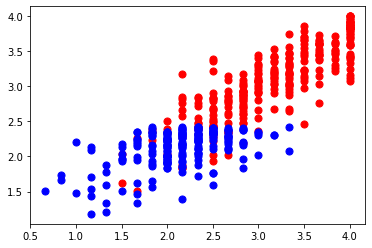

In [24]:
plt.scatter(df2_arr[pred1==-1, 0], df2_arr[pred1==-1, 1], s=50, marker='o', color='red')
plt.scatter(df2_arr[pred1==0, 0], df2_arr[pred1==0, 1], s=50, marker='o', color='blue')
plt.show()

In [25]:
dataframe['ClousterDBSCAM']=pred1

dataframe['ClousterDBSCAM'] = list(map(lambda x: 'NO' if x==0 else 'SI',dataframe['ClousterDBSCAM']))
f1_score = metrics.f1_score(df['Gano'], dataframe['ClousterDBSCAM'], pos_label='SI')
confusion = metrics.confusion_matrix(df['Gano'], dataframe['ClousterDBSCAM'])
print(f'f1_score: {f1_score}')



f1_score: 0.9909584086799277


In [26]:
Nc = range(2, 21)
parametros = {'n_clusters': Nc}

parameter_grid = ParameterGrid(parametros)

parameter_grid = ParameterGrid(parametros)
list(parameter_grid)
model = AgglomerativeClustering()
mejor_p = 0;
mejor_p= hallarMejorParametro (parameter_grid, model)
print (mejor_p)

parametro:  {'n_clusters': 2} puntaje:  0.7441439295931535
parametro:  {'n_clusters': 3} puntaje:  0.657378854809621
parametro:  {'n_clusters': 4} puntaje:  0.64728127676915
parametro:  {'n_clusters': 5} puntaje:  0.6127993597805104
parametro:  {'n_clusters': 6} puntaje:  0.6144435808926417
parametro:  {'n_clusters': 7} puntaje:  0.5942278679066247
parametro:  {'n_clusters': 8} puntaje:  0.5724853342012921
parametro:  {'n_clusters': 9} puntaje:  0.5733746215477304
parametro:  {'n_clusters': 10} puntaje:  0.5683276527933511
parametro:  {'n_clusters': 11} puntaje:  0.5689048907294927
parametro:  {'n_clusters': 12} puntaje:  0.5606797482526488
parametro:  {'n_clusters': 13} puntaje:  0.5554107440984293
parametro:  {'n_clusters': 14} puntaje:  0.5552412907904329
parametro:  {'n_clusters': 15} puntaje:  0.5584572569797637
parametro:  {'n_clusters': 16} puntaje:  0.5650258028120927
parametro:  {'n_clusters': 17} puntaje:  0.5659224112734585
parametro:  {'n_clusters': 18} puntaje:  0.56560410

In [27]:
df3= dataframe[['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses']]

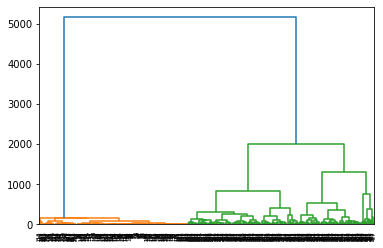

In [28]:
dendrogram = sch.dendrogram(sch.linkage(df3, method='ward'))

In [29]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(df3)
labels = model.labels_
dataframe['ClousterAglo']=labels #se agrega el array como columna del dataframe
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
dataframe['ClousterAglo'] = list(map(lambda x: 'NO' if x==1 else 'SI',dataframe['ClousterAglo']))
f1_score = metrics.f1_score(df['Gano'], dataframe['ClousterAglo'], pos_label='SI')
confusion = metrics.confusion_matrix(df['Gano'], dataframe['ClousterAglo'])
print(f'f1_score: {f1_score}')

f1_score: 0.9945355191256832


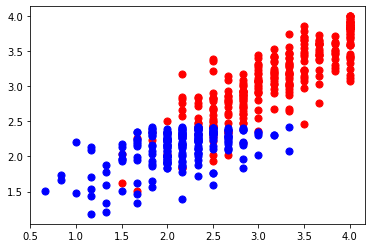

In [31]:
df3_arr=np.array(df3)

plt.scatter(df3_arr[labels==0, 0], df3_arr[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(df3_arr[labels==1, 0], df3_arr[labels==1, 1], s=50, marker='o', color='blue')
plt.show()

#conclusion:
A nivel de performance los dos cumplen con el objetivo de separar los cluster de manera correcta, con DBSCAM se tiene un f1_score: 0.9909584086799277 y con el clustering aglomerativo se tiene un f1_score: 0.9945355191256832, en cuanto entendimiento y eleccion de parametros el clustering aglomerativo es mas facil de eligir los hiperparametros que solo es el numero de cluster que se necesita.

# Punto 5

In [32]:
e1 = {
    'TaskStrategies':2,
    'SRL':3,
    'Atry to lecture':10,
    'days_act':5,
    'num_events':15,
    'num_ses':4
}

e2 = {
    'TaskStrategies':3,
    'SRL':4,
    'Atry to lecture':150,
    'days_act':15,
    'num_events':415,
    'num_ses':15
}
nuevas_entradas = pd.DataFrame.from_records([e1,e2])
nuevas_entradas

,TaskStrategies,SRL,Atry to lecture,days_act,num_events,num_ses
0,2,3,10,5,15,4
1,3,4,150,15,415,15


In [33]:
# Función que utiliza los clúster asignados para predecir si gana o no
def kmeans_predict(X):
  y_c = modelo_kmeans.predict(X)
  y_p = list(map(lambda x: 'NO' if x==0 else 'SI' if x==1 else None, y_c))
  return y_p

In [34]:
nuevas_entradas['Gano Predicho'] = kmeans_predict(nuevas_entradas)
nuevas_entradas

,TaskStrategies,SRL,Atry to lecture,days_act,num_events,num_ses,Gano Predicho
0,2,3,10,5,15,4,NO
1,3,4,150,15,415,15,SI


In [35]:
centroide0 = C[0,:]
centroide1 = C[1,:]
estudiante0 = nuevas_entradas.loc[0]
estudiante1 = nuevas_entradas.loc[1]

fig = go.Figure()
cols = ['TaskStrategies' ,'SRL', 'Atry to lecture', 'days_act', 'num_events',
 'num_ses']
fig.add_trace(go.Scatter(x=cols,y=centroide0, mode='lines',name='Centroide NO', line={"color":graficar.colores['incorrecto']}))
fig.add_trace(go.Scatter(x=cols,y=centroide1, mode='lines', name='Centroide SI', line={"color":graficar.colores['correcto']}))
fig.add_trace(go.Scatter(x=cols,y=estudiante0, mode='lines', name='Estudiante 0', line={"color":graficar.colores['c3']}))
fig.add_trace(go.Scatter(x=cols,y=estudiante1, mode='lines', name='Estudiante 1', line={"color":graficar.colores['c3']}))
fig.show()

# Punto 6

In [36]:
# Pasando las variables a niveles
est = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
est.fit(df[cols])
Xt = pd.DataFrame(est.transform(df[cols]), columns=cols)

In [37]:
# Asignando nombres a los niveles
for column in cols:
  Xt[column] = pd.cut(Xt[column], bins=[0,1,2,3,4,5],right=False,labels=['Muy bajo', 'Bajo', 'Medio', 'Alto', 'Muy alto'])
Xt

,TaskStrategies,SRL,Atry to lecture,days_act,num_events,num_ses
0,Muy bajo,Muy bajo,Muy bajo,Bajo,Muy bajo,Muy bajo
1,Muy bajo,Bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo
2,Muy bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo
3,Muy bajo,Bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo
4,Muy bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo,Muy bajo
...,...,...,...,...,...,...
489,Muy alto,Muy alto,Muy alto,Bajo,Bajo,Bajo
490,Muy alto,Muy alto,Muy alto,Bajo,Bajo,Bajo
491,Muy alto,Muy alto,Muy alto,Bajo,Bajo,Bajo
492,Medio,Bajo,Muy alto,Medio,Medio,Bajo


In [38]:
# Creando la matriz por cada nivel utilizando one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Xt)
Xtt = enc.transform(Xt)>0

In [39]:
df_apriori = pd.DataFrame.sparse.from_spmatrix(Xtt,columns=enc.get_feature_names_out())

In [40]:
frequent_itemsets = apriori(df_apriori, min_support=0.06,use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.246964,(TaskStrategies_Alto)
1,0.095142,(TaskStrategies_Bajo)
2,0.366397,(TaskStrategies_Medio)
3,0.269231,(TaskStrategies_Muy alto)
4,0.216599,(SRL_Alto)


In [41]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)

In [42]:
# Eliminando reglas redundantes
# Se ordenan por confianza descendentemente para cuando haya un duplicado escoger aquella que tenga mayor confianza
rules.sort_values(by=['confidence'],ascending=False,inplace=True)
# Se crea la columna llave que almacenará la concatenación ordenada del antecedente y consequente, de esta forma, detectara los duplicados sin importar el orden original de estas dos columnas
rules['llave'] = rules.apply(lambda x: ''.join(sorted((str(x['antecedents']),str(x['consequents'])))),axis=1)
# Se eliminan duplicados escogiendo la primera fila (La que tiene mayor confianza)
rules.drop_duplicates(subset='llave',inplace=True,keep='first')
rules.drop(columns=['llave'], inplace=True)

In [43]:
sorted_by_support_confidence = rules.sort_values(by=['support','confidence'],ascending=False)
best_rules = rules.sort_values(by=['support','confidence'],ascending=False).head()
sorted_by_confidence = sorted_by_support_confidence[5:].sort_values(by=['confidence'],ascending=False)
best_rules = best_rules.append(sorted_by_confidence.head())

In [44]:
def format_rules(rules):
  reglas = []
  for row in best_rules.iloc:
    antecedentes = ' y '.join(['"'+x+'"' for x in row['antecedents']])
    consecuentes = ' y '.join(['"'+x+'"' for x in row['consequents']])
    reglas.append(f'Sí {antecedentes} entonces {consecuentes}. Soporte: {row["support"]:.2%}, Confianza: {row["confidence"]:.2%}')
  return '\n'.join(reglas)

In [45]:
print(format_rules(best_rules))

Sí "days_act_Muy bajo" entonces "num_ses_Muy bajo". Soporte: 44.94%, Confianza: 95.69%
Sí "Atry to lecture_Muy bajo" entonces "num_events_Muy bajo". Soporte: 44.13%, Confianza: 100.00%
Sí "num_events_Muy bajo" entonces "num_ses_Muy bajo". Soporte: 44.13%, Confianza: 88.62%
Sí "days_act_Muy bajo" entonces "num_events_Muy bajo". Soporte: 42.31%, Confianza: 90.09%
Sí "num_events_Muy bajo" y "days_act_Muy bajo" entonces "num_ses_Muy bajo". Soporte: 41.70%, Confianza: 98.56%
Sí "num_ses_Muy bajo" y "TaskStrategies_Bajo" entonces "num_events_Muy bajo" y "days_act_Muy bajo". Soporte: 7.69%, Confianza: 100.00%
Sí "SRL_Bajo" y "TaskStrategies_Medio" y "days_act_Muy bajo" entonces "num_events_Muy bajo". Soporte: 14.98%, Confianza: 100.00%
Sí "SRL_Bajo" y "TaskStrategies_Medio" y "days_act_Muy bajo" entonces "Atry to lecture_Muy bajo". Soporte: 14.98%, Confianza: 100.00%
Sí "num_events_Muy bajo" y "SRL_Bajo" y "TaskStrategies_Medio" y "days_act_Muy bajo" entonces "Atry to lecture_Muy bajo". Sopor

Se encuentra que aquellas personas que vieron videos después de hacer el test muy pocas veces, también asistieron a muy pocos eventos, adicionalmente, se encuentra que una baja autopercepción con respecto a sus estrategias de estudio y muy poca asistencia a sesiones, impacta directamente en la cantidad de días asistidos, dando como resultado que alrededor del 40% de los alumnos perdieron el curso.

# Punto 7

In [79]:
# Cargando conjunto de datos
archivo_cesta = ''.join([parent, r'/PEC3/supermercadoExcel.xlsx'])
data = pd.read_excel(archivo_cesta)

In [80]:
# Transformando los datos
data.fillna(False, inplace=True)
data.replace(to_replace='t', value=True, inplace=True)
data.head()

,department1,department2,department3,department4,department5,department6,department7,department8,department9,grocery misc,...,department208,department209,department210,department211,department212,department213,department214,department215,department216,total
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,high
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,low


Primero se se dejarán aquellas columnas que no estén relacionadas con productos, por ejemplo aquellas que comienzan con departamento y total.

In [82]:
columnas_departamento = [x for x in data.columns if 'department' == x[:10]] + ['total']
tdata = data.drop(columns=columnas_departamento)
[print(";" + dato + ";") for dato in tdata.columns]

;grocery misc;
;baby needs;
;bread and cake;
;baking needs;
;coupons;
;juice-sat-cord-ms;
;tea;
;biscuits;
;canned fish-meat;
;canned fruit;
;canned vegetables;
;breakfast food;
;cigs-tobacco pkts;
;cigarette cartons;
;cleaners-polishers;
;coffee;
;sauces-gravy-pkle;
;confectionary;
;puddings-deserts;
;dishcloths-scour;
;deod-disinfectant;
;frozen foods;
;razor blades;
;fuels-garden aids;
;spices;
;jams-spreads;
;insecticides;
;pet foods;
;laundry needs;
;party snack foods;
;tissues-paper prd;
;wrapping;
;dried vegetables;
;pkt-canned soup;
;soft drinks;
;health food other;
;beverages hot;
;health&beauty misc;
;deodorants-soap;
;mens toiletries;
;medicines;
;haircare;
;dental needs;
;lotions-creams;
;sanitary pads;
;cough-cold-pain;
;meat misc;
;cheese;
;chickens;
;milk-cream;
;cold-meats;
;deli gourmet;
;margarine;
;salads;
;small goods;
;dairy foods;
;fruit drinks;
;delicatessen misc;
;beef;
;hogget;
;lamb;
;pet food;
;pork;
;poultry;
;veal;
;gourmet meat;
;produce misc;
;fruit;
;pla

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Se evidencia que al final queda una columna que no es útil, se seleccionaran las primeras

In [84]:
columnas = ['grocery misc','baby needs','bread and cake','baking needs','coupons','juice-sat-cord-ms','tea','biscuits','canned fish-meat','canned fruit','canned vegetables','breakfast food','cigs-tobacco pkts','cigarette cartons','cleaners-polishers','coffee','sauces-gravy-pkle','confectionary','puddings-deserts','dishcloths-scour','deod-disinfectant','frozen foods','razor blades','fuels-garden aids','spices','jams-spreads','insecticides','pet foods','laundry needs','party snack foods','tissues-paper prd','wrapping','dried vegetables','pkt-canned soup','soft drinks','health food other','beverages hot','health&beauty misc','deodorants-soap','mens toiletries','medicines','haircare','dental needs','lotions-creams','sanitary pads','cough-cold-pain','meat misc','cheese','chickens','milk-cream','cold-meats','deli gourmet','margarine','salads','small goods','dairy foods','fruit drinks','delicatessen misc','beef','hogget','lamb','pet food','pork','poultry','veal','gourmet meat','produce misc','fruit','plants','potatoes','vegetables','flowers','variety misc','brushware','electrical','haberdashery','kitchen','manchester','pantyhose','plasticware','stationary','prepared meals','preserving needs','condiments','cooking oils','health food bulk','bake off products','small goods2','offal','mutton','trim pork','trim lamb','imported cheese','casks white wine','casks red wine','750ml white nz','750ml red nz','750ml white imp','750ml red imp','sparkling nz','sparkling imp','brew kits/accesry','port and sherry','ctrled label wine','non host support']
tdata = tdata.reindex(columns=columnas)
tdata

,grocery misc,baby needs,bread and cake,baking needs,coupons,juice-sat-cord-ms,tea,biscuits,canned fish-meat,canned fruit,...,750ml white nz,750ml red nz,750ml white imp,750ml red imp,sparkling nz,sparkling imp,brew kits/accesry,port and sherry,ctrled label wine,non host support
0,False,True,True,True,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4622,False,False,True,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4623,False,False,True,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4624,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4625,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Para realizar el análisis de cesta de mercado, primero se entrenará un modelo para encontrar reglas de asociación entre los productos.

In [94]:
cesta_frequent_itemsets = apriori(tdata, min_support=0.06, use_colnames=True)
cesta_frequent_itemsets.sort_values(by='support',inplace=True,ascending=False)
cesta_frequent_itemsets.head()

,support,itemsets
1,0.719689,(bread and cake)
48,0.640156,(fruit)
50,0.639939,(vegetables)
38,0.635185,(milk-cream)
2,0.604063,(baking needs)


In [95]:
cesta_rules = association_rules(cesta_frequent_itemsets, metric='confidence', min_threshold=0.8)

In [96]:
# Eliminando reglas redundantes
# Se ordenan por confianza descendentemente para cuando haya un duplicado escoger aquella que tenga mayor confianza
cesta_rules.sort_values(by=['confidence'],ascending=False,inplace=True)
# Se crea la columna llave que almacenará la concatenación ordenada del antecedente y consequente, de esta forma, detectara los duplicados sin importar el orden original de estas dos columnas
cesta_rules['llave'] = cesta_rules.apply(lambda x: ''.join(sorted((str(x['antecedents']),str(x['consequents'])))),axis=1)
# Se eliminan duplicados escogiendo la primera fila (La que tiene mayor confianza)
cesta_rules.drop_duplicates(subset='llave',inplace=True,keep='first')
cesta_rules.drop(columns=['llave'], inplace=True)

In [97]:
# Reglas con mayor soporte y luego confianza
sorted_by_support_confidence = cesta_rules.sort_values(by=['support','confidence'],ascending=False)
best_rules = cesta_rules.sort_values(by=['support','confidence'],ascending=False).head()

# Reglas con mayor confianza
sorted_by_confidence = sorted_by_support_confidence[5:].sort_values(by=['confidence'],ascending=False)
best_rules = best_rules.append(sorted_by_confidence.head())

In [98]:
print(format_rules(best_rules))

Sí "margarine" entonces "bread and cake". Soporte: 39.57%, Confianza: 80.03%
Sí "vegetables" y "fruit" entonces "bread and cake". Soporte: 38.71%, Confianza: 81.15%
Sí "fruit" y "milk-cream" entonces "bread and cake". Soporte: 36.40%, Confianza: 82.63%
Sí "vegetables" y "milk-cream" entonces "bread and cake". Soporte: 35.83%, Confianza: 81.88%
Sí "vegetables" y "baking needs" entonces "bread and cake". Soporte: 34.28%, Confianza: 81.38%
Sí "vegetables" y "fruit" y "margarine" y "frozen foods" y "biscuits" y "milk-cream" y "pet foods" entonces "bread and cake". Soporte: 6.14%, Confianza: 95.62%
Sí "vegetables" y "fruit" y "margarine" y "frozen foods" y "milk-cream" y "pet foods" y "baking needs" entonces "bread and cake". Soporte: 6.46%, Confianza: 95.53%
Sí "fruit" y "margarine" y "frozen foods" y "biscuits" y "milk-cream" y "pet foods" y "baking needs" entonces "bread and cake". Soporte: 6.09%, Confianza: 95.27%
Sí "vegetables" y "margarine" y "frozen foods" y "biscuits" y "milk-cream

Al analizar los datos se evidencia que los productos mas vendidos son:

- Pan  
- Frutas  
- Vegetales  
- Leche  
- Insumos para hornear

Se recomienda que los ítems anteriores sean puestos en un lugar de fácil acceso y visibles, por ejemplo, cerca a la caja registradora.

Adicionalmente, se evidencia que las personas que compran los siguientes elementos, por lo regular compran pan:
- Vegetales
- Mantequilla
- Fruta
- Leche
- Alimentos congelados
- Insumos para hornear
- Comida para mascotas
- Galletas
- Pasabocas
- Utensilios

Por lo tanto, se recomienda ubicar estos elementos en el fondo del supermercado, de esta manera las personas deben recorrer toda la tienda para comprar estos productos y de esta manera se pueden antojar de otros productos, aumentando así la venta de los ítems que menos se venden.